#  Rudimentos de Machine Learning

![Colegio Bourbaki](./Images/Bourbaki.png)

## Aprendizaje Supervisado

### Contexto

BNP Paribas Personal Finance es líder en financiación personal en Francia y en Europa a través de su actividad de crédito al consumo. Filial al 100% del Grupo BNP Paribas, BNP Paribas Personal Finance reúne a más de 20 000 empleados y opera en una treintena de países. Bajo diversas marcas como Cetelem, Cofinoga y Findomestic, BNP Paribas Personal Finance ofrece a sus clientes una gama completa de créditos al consumo, disponibles en tiendas y concesionarios de automóviles o directamente a través de centros de relación con el cliente y de los sitios web locales de la empresa.

BNP Paribas Personal Finance ha desarrollado una estrategia activa de apoyo a los minoristas, fabricantes y concesionarios de automóviles, comerciantes Web y diversas instituciones financieras (banca y seguros), basada en su experiencia en el mercado de crédito y su capacidad para ofrecer servicios adaptados a la actividad y la estrategia comercial de sus socios comerciales. También es un actor clave en materia de crédito responsable y de concienciación presupuestaria.

BNPP Personal Finance está, por naturaleza, expuesta al Riesgo de Crédito, y se basa en gran medida en modelos cuantitativos para gestionarlo. Dentro de BNP Paribas Personal Finance, el Departamento Central de Riesgos es responsable de la pertinencia de los modelos de calificación de riesgos utilizados en todas las entidades locales y de mantener un alto nivel de experiencia en la integración de nuevas técnicas estadísticas en nuevos entornos de modelización.

El equipo de Optimización de Procesos de Crédito forma parte del departamento de RIESGO de BNPP PF, dentro de Risk Personal Finance Global Credit Decision-making Policies, contribuimos a la racionalización y la optimización de los procesos de decisión de riesgo a través de un enfoque analítico. Apoyamos a los equipos de riesgo locales para mejorar la eficiencia de los procesos de crédito, incluida la parte de fraude, participando en el mejor equilibrio entre rentabilidad, recorrido del cliente y perfiles de riesgo.

**El fraude es un problema importante para los comerciantes. Los delincuentes utilizan una amplia variedad de métodos para atacar a las organizaciones a través de sistemas, canales, procesos y productos. Por ello, el desarrollo de métodos de detección del fraude reviste una importancia crucial. La detección del fraude es un problema difícil porque los defraudadores hacen todo lo posible para que su comportamiento parezca legítimo. Otra dificultad es que el número de registros legítimos es mucho mayor que el número de casos fraudulentos.**

Link: https://challengedata.ens.fr/participants/challenges/104/

**En nuestro caso, trabajeremos con un data ya pre-procesado para poder realizar el modelo de perceptron y SVM**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### Librerias

In [2]:
# Data Analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Classificaon
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC

# Utils
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils.class_weight import compute_class_weight

### Funciones de ayuda

In [3]:
def plot_correlation_matrix(dataframe, plot_graph=True, return_matrix=False):
    """
    Calculates and optionally plots the correlation matrix of a given DataFrame.
    
    Parameters:
    - dataframe: DataFrame from which to calculate the correlation matrix.
    - plot_graph: If True, displays a heatmap of the correlation matrix.
    - return_matrix: If True, returns the correlation matrix.
    
    Returns:
    - If return_matrix is True, returns the correlation matrix of the dataframe.
    """
    # Calculate the correlation matrix
    correlation_matrix = dataframe.corr('spearman')
    
    # Plot the correlation matrix heatmap if requested
    if plot_graph:
        plt.figure(figsize=(25, 20))
        sns.heatmap(correlation_matrix, vmin=-1, vmax=1, center=0, cmap="hot", annot=True, fmt=".2f", square=True)
        plt.xticks(rotation=45, horizontalalignment='right')
    
    # Return the correlation matrix if requested
    if return_matrix:
        return correlation_matrix

In [4]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plots a confusion matrix using Seaborn's heatmap.

    Parameters:
    - y_true: array-like of shape (n_samples,), True labels of the data.
    - y_pred: array-like of shape (n_samples,), Predicted labels.

    Returns:
    - None, displays a confusion matrix.
    """
    # Compute confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred)

    # Create a DataFrame for Seaborn's heatmap
    confusion_df = pd.DataFrame(confusion_mat, index=['Real Negative', 'Real Positive'], columns=['Predicted Negative', 'Predicted Positive'])
    
    # Plotting the heatmap
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

### Carga de Datos

In [5]:
#df = pd.read_csv('./drive/MyDrive/Data/FraudeCanastas.csv') #Colab
df = pd.read_csv('./Data/FraudeCanastas.csv') #Colab

In [6]:
df.head()

,ID,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
0,130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1299,649.500000,1299,0.0,1.0
1,195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3,3,4119,1373.000000,2470,0.0,1.0
2,217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,2806,1403.000000,2799,7.0,1.0
3,552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1206,603.000000,1199,7.0,1.0
4,854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,19,27,1807,66.925926,195,4.0,1.0


In [7]:
df.tail()

,ID,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
9314,110381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1,369,369.00,369,369.0,0.0
9315,111244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,16,20,2667,133.35,423,15.0,0.0
9316,44253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1,849,849.00,849,849.0,0.0
9317,87960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1906,953.00,1899,7.0,0.0
9318,49022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1629,814.50,1549,80.0,0.0


In [8]:
df.columns

Index(['ID', 'APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90',
       'AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H',
       'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE',
       'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI',
       'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE',
       'AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND',
       'AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD',
       'AUDIO ACCESSORIES | APPLE | AIRPODS PRO',
       'AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX',
       ...
       'WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY',
       'WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT',
       'WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10',
       'Nb_of_items', 'total_of_items', 'costo_tot

In [9]:
df

,ID,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
0,130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1299,649.500000,1299,0.0,1.0
1,195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3,3,4119,1373.000000,2470,0.0,1.0
2,217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,2806,1403.000000,2799,7.0,1.0
3,552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1206,603.000000,1199,7.0,1.0
4,854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,19,27,1807,66.925926,195,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9314,110381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1,369,369.000000,369,369.0,0.0
9315,111244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,16,20,2667,133.350000,423,15.0,0.0
9316,44253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1,1,849,849.000000,849,849.0,0.0
9317,87960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1906,953.000000,1899,7.0,0.0


In [10]:
df = df.set_index('ID')

In [11]:
df.head()

,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX NOISE CANCELLING WIRELESS BLUETO,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
ID,,,,,,,,,,,,,,,,,,,,,
130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1299,649.500000,1299,0.0,1.0
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3,3,4119,1373.000000,2470,0.0,1.0
217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,2806,1403.000000,2799,7.0,1.0
552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,2,1206,603.000000,1199,7.0,1.0
854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,19,27,1807,66.925926,195,4.0,1.0


In [12]:
df.describe()

,APPLE PRODUCTDESCRIPTION | SAMSUNG | MODEL90,AUDIO ACCESSORIES | AB AUDIO | AB AUDIO GO AIR TRUE WIRELESS BLUETOOTH IN-EAR H,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH CHARGING CASE 2ND GENERATI,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE,AUDIO ACCESSORIES | APPLE | 2019 APPLE AIRPODS WITH WIRELESS CHARGING CASE 2ND,AUDIO ACCESSORIES | APPLE | 2021 APPLE AIRPODS WITH MAGSAFE CHARGING CASE 3RD,AUDIO ACCESSORIES | APPLE | AIRPODS PRO,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX,AUDIO ACCESSORIES | APPLE | APPLE AIRPODS MAX NOISE CANCELLING WIRELESS BLUETO,...,WOMEN S NIGHTWEAR | ANYDAY RETAILER | ANYDAY RETAILER LEOPARD PRINT JERSEY PY,WOMEN S NIGHTWEAR | RETAILER | RETAILER CLEO VELOUR JOGGER LOUNGE PANT,WOMEN S NIGHTWEAR | SOSANDAR | SOSANDAR ZEBRA PRINT PYJAMA BOTTOMS BLACK 10,Nb_of_items,total_of_items,costo_total,costo_medio_item,costo_item_max,costo_item_min,fraud_flag
count,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,...,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000,9319.000000
mean,0.107308,0.002146,0.305290,0.207533,0.050971,0.014916,0.292521,0.230175,0.353471,1.466144,...,0.003005,0.001932,0.002790,1.774761,1.856852,1337.801052,898.376189,1184.433416,647.735165,0.141539
std,10.358941,0.207179,7.606907,6.133545,2.843956,1.439893,6.848110,6.695964,13.926653,27.269129,...,0.290050,0.186461,0.269332,1.541868,1.922323,1070.597321,734.425487,786.942018,841.194373,0.348595
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,219.000000,41.615385,130.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,838.000000,445.500000,749.000000,7.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1124.000000,745.400000,1049.000000,379.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,2.000000,1612.000000,1150.000000,1415.500000,1099.000000,0.000000
max,1000.000000,20.000000,500.000000,436.000000,168.000000,139.000000,169.000000,195.000000,549.000000,549.000000,...,28.000000,18.000000,26.000000,38.000000,44.000000,24551.000000,19999.000000,19999.000000,19999.000000,1.000000


In [13]:
print(f'Los valores nulos son {sum(df.isnull().sum())}')

Los valores nulos son 0


In [14]:
# Distribution of the fraud flag
fraud_distribution = df['fraud_flag'].value_counts(normalize=True) * 100

In [15]:
fraud_distribution

fraud_flag
0.0    85.846121
1.0    14.153879
Name: proportion, dtype: float64

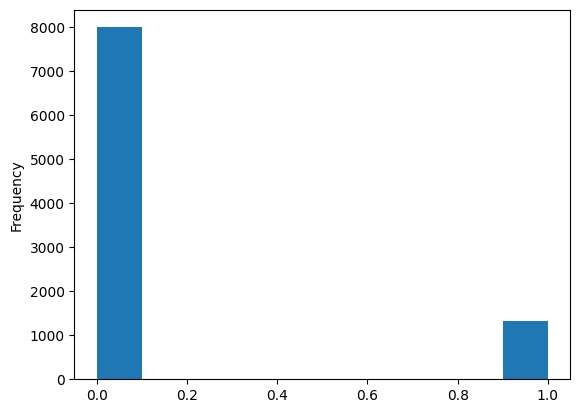

In [16]:
df['fraud_flag'].plot(kind='hist')
plt.show()

Data Splitting

In [17]:
#Separar las etiquetas del conjunto de datos
X = df.drop('fraud_flag', axis=1)
y = df['fraud_flag']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True) 

In [19]:
# imprime los conjuntos de entrenamiento y prueba
print("TRAINING SET")
print("X: ", X_train.shape)
print("y: ", y_train.shape)
print('Fraude:{:7.3f}%'.format(y_train.mean()*100),'\n')

print("TEST SET")
print("X: ", X_test.shape)
print("y: ", y_test.shape)
print('Fraude:{:7.3f}%'.format(y_test.mean()*100))

TRAINING SET
X:  (7455, 2455)
y:  (7455,)
Fraude: 14.205% 

TEST SET
X:  (1864, 2455)
y:  (1864,)
Fraude: 13.948%


### Perceptron Simple

Vamos a entrenar un Perceptrón:

In [20]:
model = Perceptron(verbose=True)

In [21]:
model.fit(X_train, y_train)

-- Epoch 1
Norm: 51985.10, NNZs: 456, Bias: -33.000000, T: 7455, Avg. loss: 1042368.951989
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 56768.86, NNZs: 579, Bias: -48.000000, T: 14910, Avg. loss: 1038018.470731
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 67325.71, NNZs: 691, Bias: -40.000000, T: 22365, Avg. loss: 1034607.300368
Total training time: 0.11 seconds.
-- Epoch 4
Norm: 72684.39, NNZs: 747, Bias: -49.000000, T: 29820, Avg. loss: 940829.818704
Total training time: 0.15 seconds.
-- Epoch 5
Norm: 82322.29, NNZs: 822, Bias: -41.000000, T: 37275, Avg. loss: 1029114.022821
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 87403.55, NNZs: 900, Bias: -37.000000, T: 44730, Avg. loss: 982666.609087
Total training time: 0.22 seconds.
-- Epoch 7
Norm: 91476.99, NNZs: 952, Bias: -30.000000, T: 52185, Avg. loss: 989756.146834
Total training time: 0.26 seconds.
-- Epoch 8
Norm: 94360.71, NNZs: 959, Bias: -42.000000, T: 59640, Avg. loss: 907756.808499
Total training time: 0.3

Perceptron(verbose=True)

In [22]:
y_pred = model.predict(X_test)

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      1604
         1.0       0.33      0.22      0.27       260

    accuracy                           0.83      1864
   macro avg       0.61      0.58      0.58      1864
weighted avg       0.80      0.83      0.81      1864



In [24]:
print(
    "Precisión conjunto entrenamiento: %.2f%%" % (model.score(X_train, y_train) * 100.0)
)
print("Precisión conjunto prueba: %.2f%%" % (model.score(X_test, y_test) * 100.0))

Precisión conjunto entrenamiento: 83.93%
Precisión conjunto prueba: 82.89%


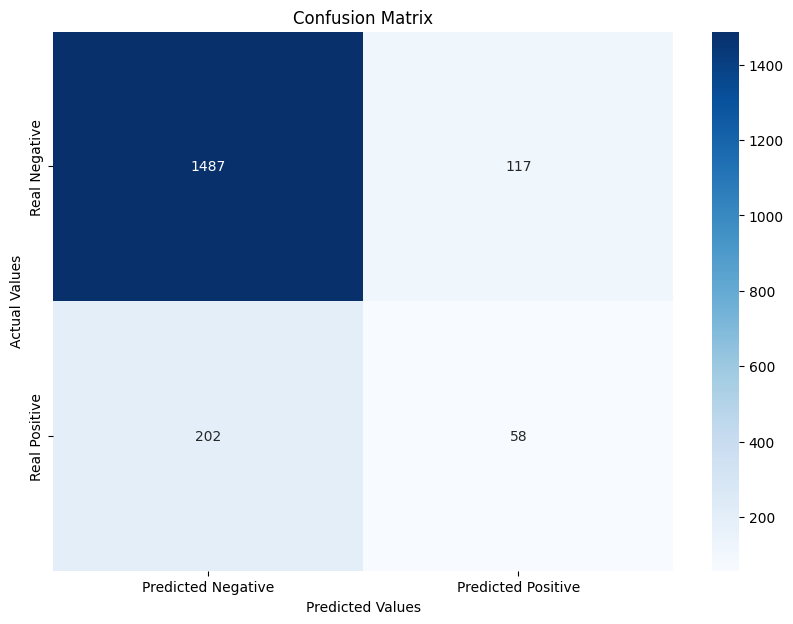

In [25]:
plot_confusion_matrix(y_test, y_pred)

Perceptron balanceado

In [26]:
class_weights = dict(
    zip(np.unique(y), compute_class_weight("balanced", classes=np.unique(y), y=y))
)

In [27]:
class_weights

{0.0: 0.5824375, 1.0: 3.5326004548900682}

In [28]:
model_balanced = Perceptron(verbose=True, class_weight='balanced') 

In [29]:
model_balanced.fit(X_train, y_train)     

-- Epoch 1
Norm: 102045.67, NNZs: 1018, Bias: -102.770122, T: 7455, Avg. loss: 4507542.748501
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 119632.07, NNZs: 1275, Bias: -150.679103, T: 14910, Avg. loss: 3408474.332349
Total training time: 0.08 seconds.
-- Epoch 3
Norm: 140646.84, NNZs: 1411, Bias: -206.788363, T: 22365, Avg. loss: 3370444.186184
Total training time: 0.12 seconds.
-- Epoch 4
Norm: 150802.48, NNZs: 1512, Bias: -198.231478, T: 29820, Avg. loss: 3100411.287099
Total training time: 0.16 seconds.
-- Epoch 5
Norm: 160972.58, NNZs: 1567, Bias: -164.452997, T: 37275, Avg. loss: 3080165.318855
Total training time: 0.19 seconds.
-- Epoch 6
Norm: 176637.94, NNZs: 1635, Bias: -178.555430, T: 44730, Avg. loss: 3641950.466289
Total training time: 0.24 seconds.
-- Epoch 7
Norm: 187499.42, NNZs: 1662, Bias: -174.124275, T: 52185, Avg. loss: 3198306.055131
Total training time: 0.29 seconds.
-- Epoch 8
Norm: 200185.46, NNZs: 1706, Bias: -162.445439, T: 59640, Avg. loss: 4203282.708

Perceptron(class_weight='balanced', verbose=True)

In [30]:
y_pred = model_balanced.predict(X_test)

Veamos las métricas del modelo:

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91      1604
         1.0       0.43      0.28      0.34       260

    accuracy                           0.85      1864
   macro avg       0.66      0.61      0.63      1864
weighted avg       0.82      0.85      0.83      1864



In [32]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 83.93%
Precisión conjunto prueba: 82.89%


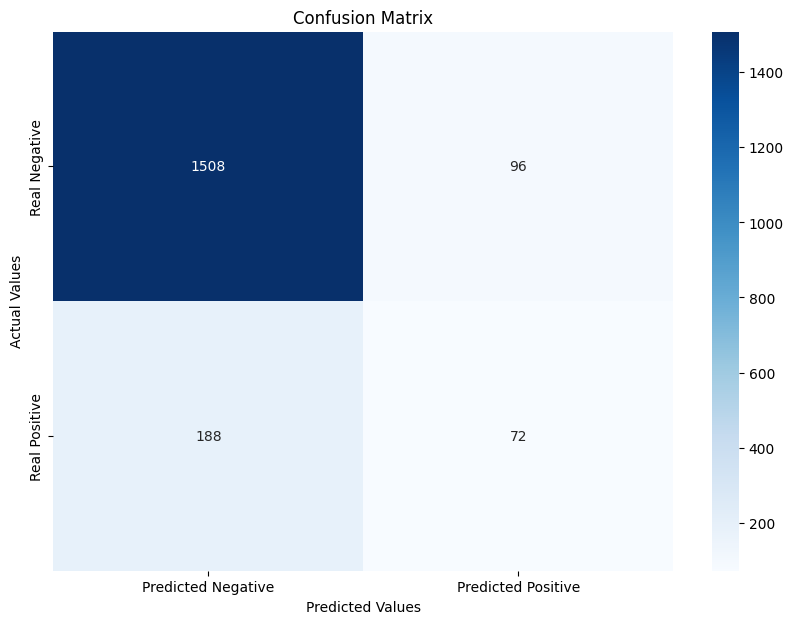

In [33]:
plot_confusion_matrix(y_test, y_pred)

Veamos ahora la clasificación con Perceptron con margen:

In [34]:
model_margin = Perceptron(penalty='l1', verbose=True, alpha=0.00005, class_weight='balanced') 

In [35]:
model_margin.fit(X_train,y_train)     

-- Epoch 1
Norm: 102050.74, NNZs: 1018, Bias: -102.770122, T: 7455, Avg. loss: 4507466.109210
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 119646.07, NNZs: 1275, Bias: -150.679103, T: 14910, Avg. loss: 3408365.928574
Total training time: 0.21 seconds.
-- Epoch 3
Norm: 140666.37, NNZs: 1411, Bias: -206.788363, T: 22365, Avg. loss: 3370424.723030
Total training time: 0.33 seconds.
-- Epoch 4
Norm: 150829.81, NNZs: 1512, Bias: -198.231478, T: 29820, Avg. loss: 3100352.921292
Total training time: 0.45 seconds.
-- Epoch 5
Norm: 161004.55, NNZs: 1566, Bias: -164.452997, T: 37275, Avg. loss: 3080336.662065
Total training time: 0.55 seconds.
-- Epoch 6
Norm: 176677.42, NNZs: 1634, Bias: -178.555430, T: 44730, Avg. loss: 3641705.859122
Total training time: 0.66 seconds.
-- Epoch 7
Norm: 187548.07, NNZs: 1659, Bias: -174.124275, T: 52185, Avg. loss: 3198199.772588
Total training time: 0.77 seconds.
-- Epoch 8
Norm: 200528.61, NNZs: 1701, Bias: -156.317104, T: 59640, Avg. loss: 4309234.111

Perceptron(alpha=5e-05, class_weight='balanced', penalty='l1', verbose=True)

In [36]:
y_pred = model_margin.predict(X_test)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.81      0.86      1604
         1.0       0.34      0.61      0.43       260

    accuracy                           0.78      1864
   macro avg       0.63      0.71      0.65      1864
weighted avg       0.84      0.78      0.80      1864



In [38]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model_margin.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_margin.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 79.52%
Precisión conjunto prueba: 77.84%


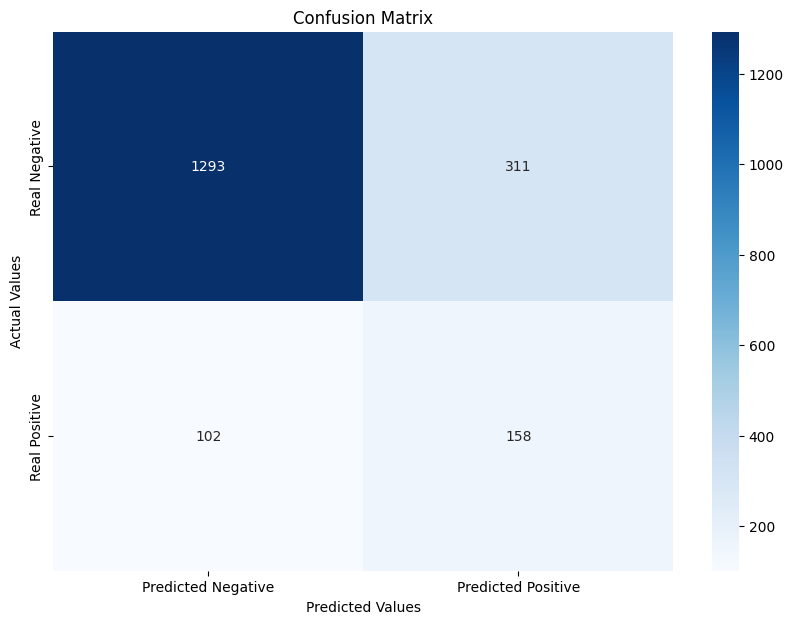

In [39]:
plot_confusion_matrix(y_test, y_pred)

In [40]:
model_margin_1 = Perceptron(penalty='l1', verbose=True, alpha=0.0005, class_weight='balanced') 

In [41]:
model_margin_1.fit(X_train,y_train)

-- Epoch 1
Norm: 102096.32, NNZs: 1013, Bias: -102.770122, T: 7455, Avg. loss: 4506776.114707
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 130651.51, NNZs: 1282, Bias: -151.308116, T: 14910, Avg. loss: 4659099.695088
Total training time: 0.27 seconds.
-- Epoch 3
Norm: 145812.21, NNZs: 1386, Bias: -209.050168, T: 22365, Avg. loss: 3419996.557728
Total training time: 0.38 seconds.
-- Epoch 4
Norm: 152719.90, NNZs: 1452, Bias: -179.957089, T: 29820, Avg. loss: 3186546.361791
Total training time: 0.50 seconds.
-- Epoch 5
Norm: 165829.62, NNZs: 1491, Bias: -167.274474, T: 37275, Avg. loss: 3130651.400428
Total training time: 0.59 seconds.
-- Epoch 6
Norm: 175983.42, NNZs: 1512, Bias: -175.687726, T: 44730, Avg. loss: 3291568.947704
Total training time: 0.70 seconds.
-- Epoch 7
Norm: 189852.82, NNZs: 1540, Bias: -200.164743, T: 52185, Avg. loss: 3208846.467148
Total training time: 0.80 seconds.
-- Epoch 8
Norm: 201684.15, NNZs: 1568, Bias: -190.863279, T: 59640, Avg. loss: 4424818.383

Perceptron(alpha=0.0005, class_weight='balanced', penalty='l1', verbose=True)

In [42]:
y_pred = model_margin_1.predict(X_test)

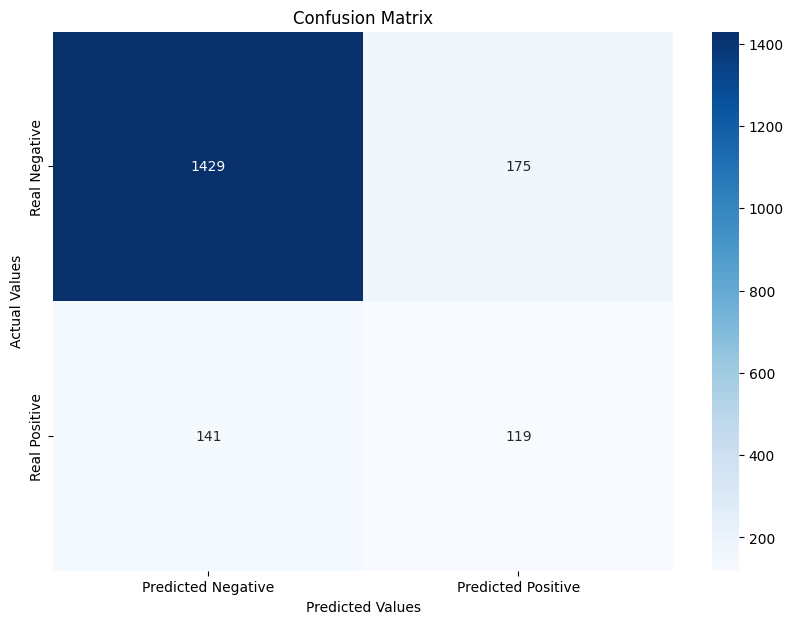

In [43]:
plot_confusion_matrix(y_test, y_pred)

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      1604
         1.0       0.40      0.46      0.43       260

    accuracy                           0.83      1864
   macro avg       0.66      0.67      0.67      1864
weighted avg       0.84      0.83      0.83      1864



In [45]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model_margin_1.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_margin_1.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 84.52%
Precisión conjunto prueba: 83.05%


In [46]:
model_margin_2 = Perceptron(penalty='l1', verbose=True, alpha=0.005, class_weight='balanced') 

In [47]:
model_margin_2.fit(X_train,y_train)

-- Epoch 1
Norm: 103112.75, NNZs: 874, Bias: -88.177355, T: 7455, Avg. loss: 4391770.630420
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 132295.46, NNZs: 1025, Bias: -144.360909, T: 14910, Avg. loss: 4736424.367396
Total training time: 0.22 seconds.
-- Epoch 3
Norm: 148001.49, NNZs: 1088, Bias: -169.466938, T: 22365, Avg. loss: 3374546.505650
Total training time: 0.32 seconds.
-- Epoch 4
Norm: 159355.92, NNZs: 1081, Bias: -140.373859, T: 29820, Avg. loss: 3170043.192784
Total training time: 0.41 seconds.
-- Epoch 5
Norm: 169821.29, NNZs: 1083, Bias: -126.433219, T: 37275, Avg. loss: 3087443.437242
Total training time: 0.49 seconds.
-- Epoch 6
Norm: 186030.32, NNZs: 1088, Bias: -138.181395, T: 44730, Avg. loss: 3317646.896136
Total training time: 0.55 seconds.
-- Epoch 7
Norm: 194027.51, NNZs: 1078, Bias: -126.174020, T: 52185, Avg. loss: 2964753.976061
Total training time: 0.62 seconds.
-- Epoch 8
Norm: 207885.22, NNZs: 1081, Bias: -134.846471, T: 59640, Avg. loss: 4387575.75783

Perceptron(alpha=0.005, class_weight='balanced', penalty='l1', verbose=True)

In [48]:
y_pred = model_margin_2.predict(X_test)

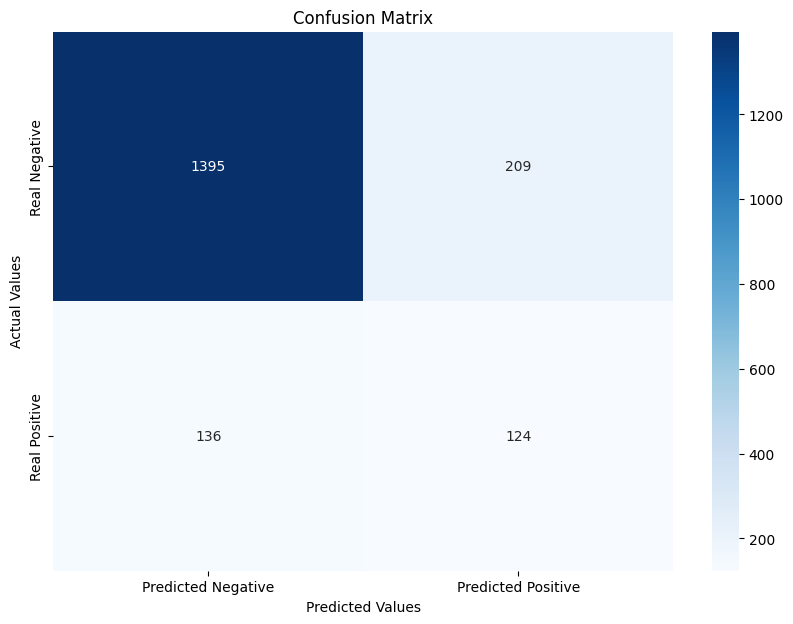

In [49]:
plot_confusion_matrix(y_test, y_pred)

In [50]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model_margin_2.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_margin_2.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 83.49%
Precisión conjunto prueba: 81.49%


Veamos otros ejemplos:

In [51]:
model_new = Perceptron(verbose=True, penalty='elasticnet', l1_ratio=0.5, shuffle=True, eta0=1e-3, early_stopping=True, validation_fraction=0.1, class_weight='balanced') 

Nota: Un modelo de regresión que utiliza la técnica de regularización L1 se denomina regresión Lasso y un modelo que utiliza L2 se denomina regresión Ridge. La diferencia clave entre estas técnicas es que Lasso reduce el coeficiente de la característica menos importante a cero, eliminando así algunas características por completo. Por lo tanto, esto funciona bien para la selección de características en caso de que tengamos un gran número de características.

In [52]:
model_new.fit(X_train,y_train)

-- Epoch 1
Norm: 89.41, NNZs: 938, Bias: -0.072201, T: 6709, Avg. loss: 4348.993761
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 132.00, NNZs: 1230, Bias: -0.108213, T: 13418, Avg. loss: 4782.326991
Total training time: 0.25 seconds.
-- Epoch 3
Norm: 161.04, NNZs: 1428, Bias: -0.145178, T: 20127, Avg. loss: 4817.160312
Total training time: 0.41 seconds.
-- Epoch 4
Norm: 157.07, NNZs: 1467, Bias: -0.098384, T: 26836, Avg. loss: 3412.177759
Total training time: 0.59 seconds.
-- Epoch 5
Norm: 165.66, NNZs: 1534, Bias: -0.066020, T: 33545, Avg. loss: 3005.234391
Total training time: 0.79 seconds.
-- Epoch 6
Norm: 186.09, NNZs: 1593, Bias: -0.061024, T: 40254, Avg. loss: 4729.377500
Total training time: 0.96 seconds.
Convergence after 6 epochs took 0.96 seconds


Perceptron(class_weight='balanced', early_stopping=True, eta0=0.001,
           l1_ratio=0.5, penalty='elasticnet', verbose=True)

In [53]:
y_pred_new = model_new.predict(X_test)

In [54]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83      1604
         1.0       0.31      0.68      0.42       260

    accuracy                           0.74      1864
   macro avg       0.62      0.71      0.63      1864
weighted avg       0.85      0.74      0.77      1864



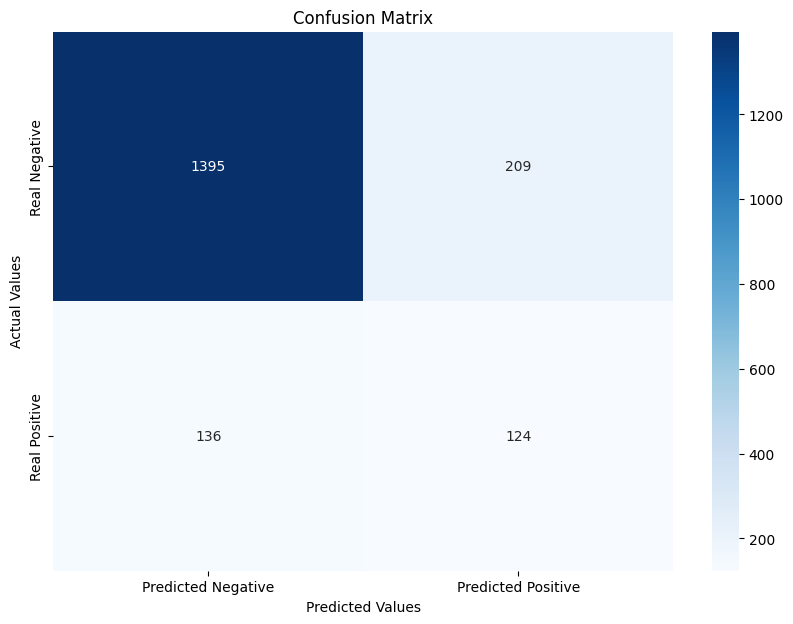

In [55]:
plot_confusion_matrix(y_test, y_pred)

In [56]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model_new.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_new.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 76.53%
Precisión conjunto prueba: 73.98%


Hagamos una búsqueda grillada:

In [57]:
# Define the parameter grid
param_grid = {
    'max_iter': [100, 1000],
    'penalty': ['l1', 'l2'], # elasticnet
    'alpha': [0.00005, 0.0005, 0.005, 0.05],
    #'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
    'shuffle': [True],
    'eta0': [1e-5, 1e-3, 1e-1],
    'early_stopping': [True],
    'validation_fraction': [0.05, 0.15],
    'class_weight': ['balanced', {0: 1, 1: 10}, None]
}

# Initialize the Perceptron model
model = Perceptron(verbose=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=6, verbose=0, scoring='recall')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print('=======================================================')
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Parameters: {'alpha': 0.0005, 'class_weight': {0: 1, 1: 10}, 'early_stopping': True, 'eta0': 1e-05, 'max_iter': 100, 'penalty': 'l1', 'shuffle': True, 'validation_fraction': 0.15}
Best Cross-Validation Score: 0.8272109451846553


In [58]:
model_grid = Perceptron(**best_params)

In [59]:
model_grid.fit(X_train, y_train)

Perceptron(alpha=0.0005, class_weight={0: 1, 1: 10}, early_stopping=True,
           eta0=1e-05, max_iter=100, penalty='l1', validation_fraction=0.15)

In [60]:
y_pred_grid = model_grid.predict(X_test)

In [61]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

         0.0       0.93      0.77      0.84      1604
         1.0       0.31      0.64      0.42       260

    accuracy                           0.75      1864
   macro avg       0.62      0.70      0.63      1864
weighted avg       0.84      0.75      0.78      1864



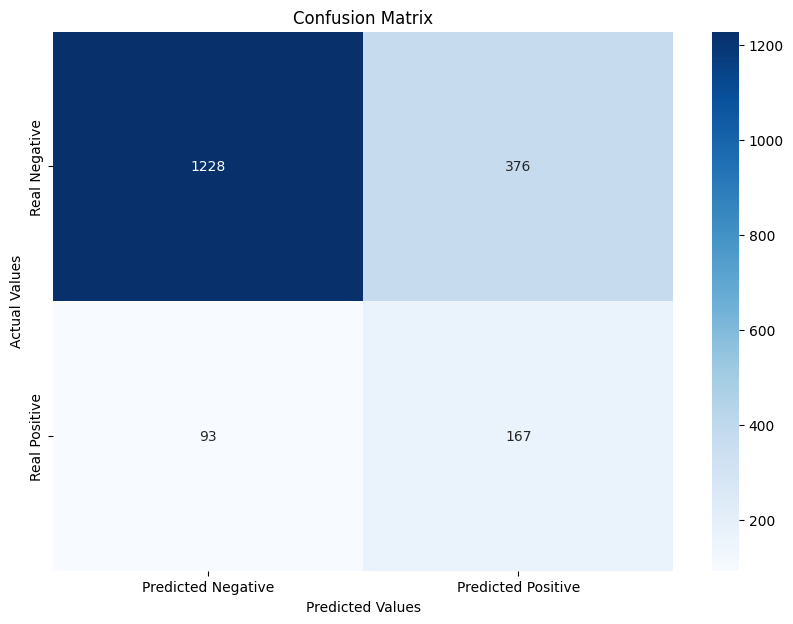

In [62]:
plot_confusion_matrix(y_test, y_pred_grid)

In [63]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model_grid.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model_grid.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 78.24%
Precisión conjunto prueba: 74.84%


Hemos disminuido los errores graves y tener un control sobre las predicciones correctas en los fraudes pero a expensas de tener un mayor número de falsos positivos.

### Maquinas de Soporte Vectorial (SVM)

In [64]:
svm_linear = LinearSVC(max_iter=500000)
svm_linear.fit(X_train, y_train)

LinearSVC(max_iter=500000)

In [65]:
y_pred = svm_linear.predict(X_test)

In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93      1604
         1.0       0.63      0.25      0.36       260

    accuracy                           0.88      1864
   macro avg       0.76      0.61      0.64      1864
weighted avg       0.85      0.88      0.85      1864



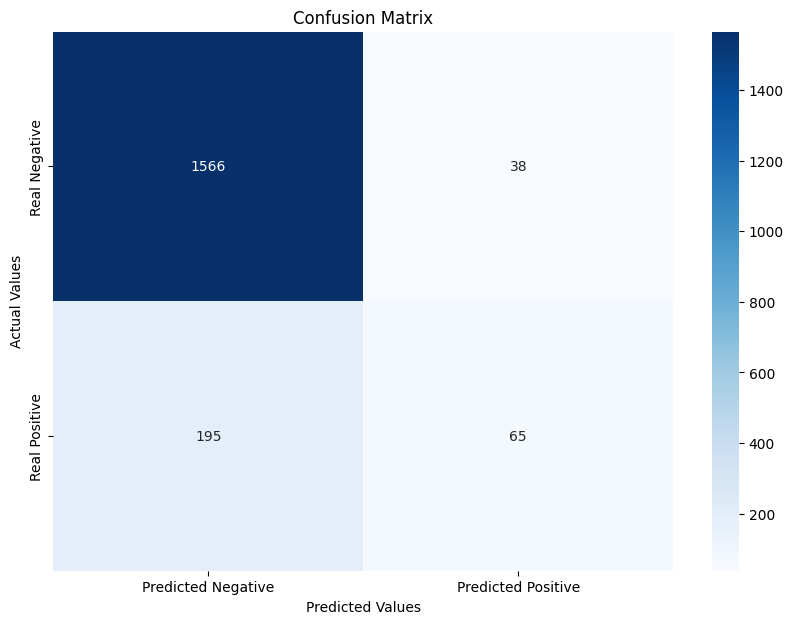

In [67]:
plot_confusion_matrix(y_test, y_pred)

In [68]:
print(
    "Precisión conjunto entrenamiento: %.2f%%"
    % (svm_linear.score(X_train, y_train) * 100.0)
)
print("Precisión conjunto prueba: %.2f%%" % (svm_linear.score(X_test, y_test) * 100.0))

Precisión conjunto entrenamiento: 88.93%
Precisión conjunto prueba: 87.50%


SVM balanceado

In [69]:
svm_linear_balanced = LinearSVC(max_iter=500000, class_weight='balanced')
svm_linear_balanced.fit(X_train, y_train)

LinearSVC(class_weight='balanced', max_iter=500000)

In [70]:
y_pred = svm_linear_balanced.predict(X_test)

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.73      0.83      1604
         1.0       0.32      0.77      0.45       260

    accuracy                           0.74      1864
   macro avg       0.63      0.75      0.64      1864
weighted avg       0.86      0.74      0.77      1864



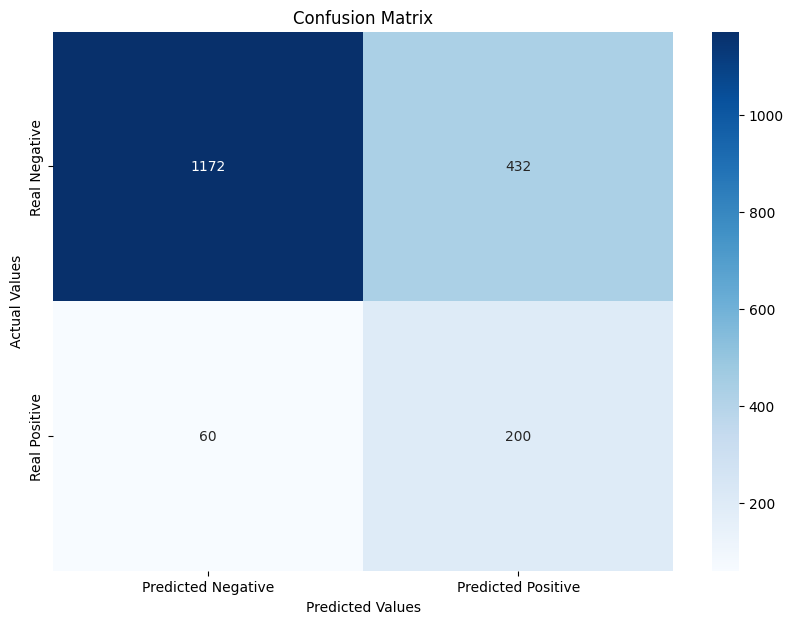

In [72]:
plot_confusion_matrix(y_test, y_pred)

In [73]:
print(
    "Precisión conjunto entrenamiento: %.2f%%"
    % (svm_linear_balanced.score(X_train, y_train) * 100.0)
)
print("Precisión conjunto prueba: %.2f%%" % (svm_linear_balanced.score(X_test, y_test) * 100.0))

Precisión conjunto entrenamiento: 76.32%
Precisión conjunto prueba: 73.61%


**¿SVM funciona mejor que el perceptrón?**

La elección entre Máquinas de Vectores de Soporte (SVM) y Perceptrón depende del problema, las características del conjunto de datos y las restricciones computacionales. A continuación, compararemos ambos métodos y en qué situaciones es mejor usar cada uno.

| Característica               | **Perceptrón**                                    | **SVM**                                          |
|------------------------------|-------------------------------------------------|--------------------------------------------------|
| **Tipo**                     | Clasificador lineal                             | Clasificador de margen máximo                   |
| **Optimización del margen**  | **No** optimiza el margen                      | Maximiza el margen para mejor generalización    |
| **Datos linealmente separables** | Funciona bien, pero sensible al ruido        | Funciona mejor al optimizar el margen           |
| **Datos no linealmente separables** | **Falla** (a menos que uses una red neuronal) | Se maneja con **kernels** (RBF, polinomial, etc.) |
| **Algoritmo de entrenamiento** | Actualización iterativa de pesos              | Optimización cuadrática                         |
| **Convergencia**             | Solo si los datos son linealmente separables   | Siempre encuentra el hiperplano óptimo          |
| **Soporte de Kernels**       | No (solo funciona con datos lineales)         | Soporta **lineal, RBF, polinomial, sigmoide**    |
| **Complejidad computacional** | \(O(n)\) por iteración, rápido de entrenar    | \(O(n^2)\) (más costoso en grandes datasets)    |
| **Robustez a valores atípicos** | No (los outliers afectan la clasificación)  | Sí (el SVM de margen suave lo maneja mejor)    |



**¿SVM funciona mejor que el perceptrón?**

La elección entre Máquinas de Vectores de Soporte (SVM) y Perceptrón depende del problema, las características del conjunto de datos y las restricciones computacionales. A continuación, compararemos ambos métodos y en qué situaciones es mejor usar cada uno.

| Característica               | **Perceptrón**                                    | **SVM**                                          |
|------------------------------|-------------------------------------------------|--------------------------------------------------|
| **Tipo**                     | Clasificador lineal                             | Clasificador de margen máximo                   |
| **Optimización del margen**  | **No** optimiza el margen                      | Maximiza el margen para mejor generalización    |
| **Datos linealmente separables** | Funciona bien, pero sensible al ruido        | Funciona mejor al optimizar el margen           |
| **Datos no linealmente separables** | **Falla** (a menos que uses una red neuronal) | Se maneja con **kernels** (RBF, polinomial, etc.) |
| **Algoritmo de entrenamiento** | Actualización iterativa de pesos              | Optimización cuadrática                         |
| **Convergencia**             | Solo si los datos son linealmente separables   | Siempre encuentra el hiperplano óptimo          |
| **Soporte de Kernels**       | No (solo funciona con datos lineales)         | Soporta **lineal, RBF, polinomial, sigmoide**    |
| **Complejidad computacional** | \(O(n)\) por iteración, rápido de entrenar    | \(O(n^2)\) (más costoso en grandes datasets)    |
| **Robustez a valores atípicos** | No (los outliers afectan la clasificación)  | Sí (el SVM de margen suave lo maneja mejor)    |



**¿Cuándo SVM es mejor que Perceptrón?**

✅ Para datos no lineales: El perceptrón solo funciona con datos linealmente separables, mientras que SVM usa kernels para clasificar datos más complejos.

✅ Para una mejor generalización: SVM maximiza el margen, lo que reduce el sobreajuste en comparación con un perceptrón.

✅ Cuando hay valores atípicos: Los perceptrones son sensibles a los puntos outliers, pero SVM de margen suave los maneja mejor.

**¿Cuándo el Perceptrón es mejor que SVM?**

✅ Si los datos son perfectamente linealmente separables y el rendimiento computacional es importante.

✅ Para grandes volúmenes de datos donde SVM es demasiado lento (el Perceptrón se entrena más rápido).

✅ Para aprendizaje en línea (datos en streaming) porque el Perceptrón puede actualizar pesos dinámicamente.


**Conclusión**
* Si los datos son linealmente separables y necesitas algo rápido, usa un Perceptrón.
* Si los datos no son lineales, SVM con kernels es muy superior.
* SVM generaliza mejor porque maximiza el margen, haciéndolo más robusto a ruido y valores atípicos.


Ejercicios:

* Realizar feature selection

* Optimizar el modelo del Perceptron.  Optar por la regularización L1 o L2.

* Comenzar el challenge desde cero y realizar el prepocesamiento. No necesariamente tienen que llegar al mismo preprocesamiento usado. Pueden tomar sus decisiones de compromiso como así lo deseen.

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)